See [README.mb](/README.mb]) file for broad overview on methodology.

## Code outline 
1. Prepare enviroment 
2. Data pre-processing 
3. **Research Question 1:** Can we accurately predict this year's (2023) happiness?
4. **Research Question 2:** What will the happiness scores be in the year 2024?
5. **Research Question 3:** Which variables are most strongly associated with happiness?
6. Future directions 
7. Conclusions 

# Prepare enviroment

We will use the Scikit-learn library as it will provide us with an interface to apply machine learning techniques.

In [ ]:
# we need to use an old version of scikit, otherwise we will face a compatiblity issue with eli5 (needed in order to use permutation importance to answer research question #3)
!pip install scikit-learn==0.22
!pip install eli5
!pip install plotly

In [3]:
# data wrangling
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr


# visualizations
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from seaborn import histplot
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='chrome' # 3d plots will be opened in browser since can't figure out how to render in notebook

# model
from sklearn.svm import SVR # this will make a support vector machine for regression
from sklearn.linear_model import LinearRegression

# permutation
import eli5
from eli5.sklearn import PermutationImportance # the downside of SVM is that it is a 'black-box', this will allow us to access our model and compute feauture importance to answer research question #3 without having to resort to do more work to prepare a i.e., decision tree or bayesian network

# scoring metric
from sklearn.metrics import r2_score, mean_squared_error # to evaluate our SVM

# formatting data
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.model_selection import GridSearchCV # this will do cross validation and allow us to find optimal parameters for our SVM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold # provides K-Fold Cross Validation, in our case we will have 10 folds (9 subsamples will be used to train the model and the remaining 1 subsample is used to validate the model)

from sklearn.pipeline import make_pipeline

# Data Pre-processing

## Import data

In [4]:
df_RAW_pre2023 = pd.read_csv('Raw Data/pre-2023.csv')
df_RAW_2023 = pd.read_csv('Raw Data/2023.csv')

## Cleaning

### Modifying columns

Let's remove the columns with variables that are not present in both datasets.

In [5]:
remove_pre2023 = ['Positive affect', 'Negative affect']

df_RAW_pre2023 = df_RAW_pre2023.drop(columns=remove_pre2023)

remove_2023 = ['Standard error of ladder score', 'upperwhisker', 'lowerwhisker',
              'Ladder score in Dystopia', 'Explained by: Log GDP per capita',
              'Explained by: Social support','Explained by: Healthy life expectancy',
              'Explained by: Freedom to make life choices','Explained by: Generosity',
              'Explained by: Perceptions of corruption','Dystopia + residual']

df_RAW_2023 = df_RAW_2023.drop(columns=remove_2023)

Add a `year` column to `df_2023` so that information is not lost if the dataframe is merged with `df_pre2023` in the future,

In [6]:
df_RAW_2023.insert(loc=1, column='year', value=2023)

**Sanity check:** Let's make sure all the dataframes have the same number of columns.

In [7]:
dataframes = [df_RAW_pre2023, df_RAW_2023]

# Count number of columns in each dataFrame
for i, df in enumerate(dataframes):
    num_columns = df.shape[1]
    print("Number of columns in DataFrame", i+1, ":", num_columns)

Number of columns in DataFrame 1 : 9
Number of columns in DataFrame 2 : 9


**Standardize naming scheme for dimensions**

Between the two datasets, there is a slight difference in the naming scheme. We need the column names to be the same to allow for merging later on.

In [8]:
df_RAW_pre2023.rename(columns={
    'Country name': 'country',
    'year': 'year',
    'Life Ladder': 'happiness',
    'Log GDP per capita': 'GDP',
    'Social support' : 'socialSupport',
    'Healthy life expectancy at birth': 'lifeExpectancy',
    'Freedom to make life choices': 'freedom',
    'Generosity': 'generosity',
    'Perceptions of corruption' : 'corruption',
}, inplace=True)

df_RAW_2023.rename(columns={
    'Country name': 'country',
    'year': 'year',
    'Ladder score': 'happiness',
    'Logged GDP per capita': 'GDP',
    'Social support' : 'socialSupport',
    'Healthy life expectancy': 'lifeExpectancy',
    'Freedom to make life choices': 'freedom',
    'Generosity': 'generosity',
    'Perceptions of corruption' : 'corruption',
}, inplace=True)

### Merge

In [9]:
df = pd.concat([df_RAW_pre2023, df_RAW_2023], axis=0)

### Dealing with NaN or 0 values

Let's make sure we do not have any NA values, since Scikit-learn's support vector machines do not work with datasets with missing values.




In [ ]:
df.dtypes # check if there are character-based place holders for missing data

`country` is an object--we'll later convert it into a binary value using one-hot encoding

In [11]:
print("Number of null or missing values: ",df.isnull().sum().sum())

Number of null or missing values:  310


According to the [statistics appendix](https://s3.amazonaws.com/happiness-report/2018/Appendix1ofChapter2.pdf) from the World Happiness Report, none of the dimensions have a minimum value of 0. Any cells that have a value of zero are actually cells with missing data.

Let's check to see if any observation has a 0 as a value.

In [12]:
zero_indices = np.where(df == 0)
num_zeros = zero_indices[0].shape[0]
print(f'Number of cells with a value of zero: {num_zeros}')

Number of cells with a value of zero: 8


While it seems that some countries have missing data, it is not justifiable to discard the whole observation. In our dataset, usually for country that has missing data, it is only empty for a single variable and still has the 6 other dimensions filled. Therefore, discarding rows with missing information is not a good tradeoff.

Luckily, we can use **linear interpolation** to estimate a resonable value for these cells and replace these cells. This method will draw a straight line between the points surrounding the missing value(s) and use this line to output an estimate. It's worth noting that we will assumes that the change between the values is constant.

Interpolation works only on cells exclusively with `NaN`. As such, we will replace all 0's with NaN's before proceeding.

In [13]:
df.replace(0, np.nan)
print("Number of null or missing values: ",df.isnull().sum().sum()) # check to see if we successfully replaced 0's

Number of null or missing values:  310


Now that our dataset exclusively has missing data as `NaN`, we can proceed with the interpolation.

In [14]:
df.interpolate(method='linear', inplace=True)
print("Number of null or missing values: ",df.isnull().sum().sum())

Number of null or missing values:  0


Success! We have no more `NaN` values in out dataset.

How many years does our dataframe account for? which countries are missing from each year?

In [20]:
unique_countrys = df['country'].nunique()
print(f"Countries: {unique_countrys}")

Countries: 165


In [21]:
years = df['year'].unique()
print(f"The dataframe covers the years: {years}")

The dataframe covers the years: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2021 2022
 2007 2020 2006 2005 2023]


In [32]:
country_counts = df['country'].value_counts()
country_counts_df = country_counts.reset_index() # Convert the series into a df
country_counts_df.columns = ['Country', 'Years_with_data']# Rename  columns

# Group by the counts and get the countries with the same counts
grouped_counts = country_counts_df.groupby('Years_with_data')['Country'].apply(list)

print(grouped_counts)

Years_with_data
1              [Maldives, Guyana, Suriname, Oman, Cuba]
2                                              [Belize]
3                           [Somalia, Bhutan, Eswatini]
4     [Angola, Djibouti, Lesotho, South Sudan, Somal...
5     [Sudan, Gambia, Qatar, Burundi, Trinidad and T...
6                                               [Libya]
7                                               [Syria]
8                                             [Comoros]
9                                             [Namibia]
10    [Turkmenistan, Jamaica, Mauritius, Congo (Kins...
11    [Algeria, Myanmar, Laos, Ethiopia, Kuwait, Ice...
12          [Ivory Coast, Togo, Rwanda, Yemen, Bahrain]
13    [Gabon, Guinea, Hong Kong S.A.R. of China, Mor...
14    [Botswana, Congo (Brazzaville), Belarus, Slova...
15    [Sierra Leone, Bosnia and Herzegovina, Serbia,...
16    [North Macedonia, Albania, Niger, Taiwan Provi...
17    [Kosovo, Poland, Philippines, Hungary, Turkiye...
18    [Lebanon, Indonesia, Kyrgy

# **Q1:** Can we accurately predict this year's (2023) happiness?

We already have the 2023 data. What we can do is train a model on the pre-2023 data to see if the predicted 2023 scores actually match the actual ones. If the model we build has a high accuracy, we can recyle the model to forecast 2024 scores!

## Pre-processing for this specific research question 

In [34]:
df_pre2023 = df[df['year'] < 2023] # we will train and test our model on this dataframe
df_2023 = df[df['year'] == 2023] # well compare predicted data with this dataframe

We need to dealing with countries present in pre-2023 data, but not 2023 (or vice versa)

In [35]:
countries_pre2023 = set(df_pre2023['country'].unique())
countries_2023 = set(df_2023['country'].unique())

# Find countries present in pre-2023 data but not 2023
missing_in_2023 = countries_pre2023 - countries_2023
print("Countries present in pre-2023 data but not 2023:")
print(missing_in_2023)

# Find countries present in 2023 data but not pre-2023
missing_in_pre2023 = countries_2023 - countries_pre2023
print("\nCountries present in 2023 data but not pre-2023:")
print(missing_in_pre2023)

Countries present in pre-2023 data but not 2023:
{'Eswatini', 'Maldives', 'Burundi', 'Qatar', 'Trinidad and Tobago', 'Somaliland region', 'Yemen', 'Belize', 'Sudan', 'Lesotho', 'Cuba', 'Angola', 'Haiti', 'Central African Republic', 'Guyana', 'Rwanda', 'Turkmenistan', 'Oman', 'Kuwait', 'Azerbaijan', 'Suriname', 'Belarus', 'Djibouti', 'Syria', 'Bhutan', 'South Sudan', 'Somalia', 'Libya'}

Countries present in 2023 data but not pre-2023:
set()


It turns out the countries the 2023 dataframe is missing are:

 'Azerbaijan', 'Turkmenistan', 'Qatar', 'Angola', 'Belize', 'Oman', 'Belarus', 'Bhutan', 'Libya', 'Kuwait', 'Trinidad and Tobago', 'Djibouti', 'Maldives', 'Cuba', 'Haiti', 'Rwanda', 'South Sudan', 'Syria', 'Central African Republic', 'Eswatini', 'Somaliland region', 'Guyana', 'Yemen', 'Suriname', 'Burundi', 'Lesotho', 'Sudan', 'Somalia'

Hence, we need to remove these countries from the pre-2023 dataframe.

In [36]:
remove_countries = ['Azerbaijan', 'Turkmenistan', 'Qatar', 'Angola', 'Belize',
                    'Oman', 'Belarus', 'Bhutan', 'Libya', 'Kuwait', 'Trinidad and Tobago',
                    'Djibouti', 'Maldives', 'Cuba', 'Haiti', 'Rwanda', 'South Sudan',
                    'Syria', 'Central African Republic', 'Eswatini', 'Somaliland region',
                    'Guyana', 'Yemen', 'Suriname', 'Burundi', 'Lesotho', 'Sudan', 'Somalia']

df_pre2023 = df_pre2023[~df_pre2023 ['country'].isin(remove_countries)] # # Filter the dataframe so only countries we want are left

To avoid data leakage, we need to split variables into indepdent and dependent variables then perform one-hot encoding. We also need to split our data into training and test sets before we scale our data.

## **Dataset splitting:** Split the data into dependent and independent variables

In this case, the variable we want to predict is data from the 'happiness' coloumn. We will store this in **y**.

The remaining other coloumns will correspond to our classification variables. This data will be store in **X**.

So the independent variables are: `country`, `year`, `GDP`, `socialSupport`,`lifeExpectancy`, `freedom`, `generosity`, `corruption`

In [39]:
X = df_pre2023.drop('happiness', axis=1).copy() # make a copy so as to not modify the original.
X_2023 = df_2023.drop('happiness', axis=1).copy()

In [40]:
y = df_pre2023['happiness'].copy()
y_2023 = df_2023['happiness'].copy()

## **Dataset sp**Splitting into training and test set & scaling 

In [42]:
# lets create folds and tell the KFold function whether or not to shuffle the data beforehand.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [43]:
# Initialize the scaler
scaler = StandardScaler()

# Prepare empty lists to hold the training and testing data for each fold
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for train_index, test_index in kf.split(X_encoded):
    # Split the data
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the scaler on the training set and transform both sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Append to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [41]:
X_encoded = pd.get_dummies(X, columns=['country'])
X_encoded_2023 = pd.get_dummies(X_2023, columns=['country'])
X_encoded.head()

,year,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption,country_Afghanistan,country_Albania,country_Algeria,...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zambia,country_Zimbabwe
0,2008,7.350,0.451,50.5,0.718,0.168,0.882,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,7.509,0.552,50.8,0.679,0.191,0.850,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,7.614,0.539,51.1,0.600,0.121,0.707,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,7.581,0.521,51.4,0.496,0.164,0.731,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,7.661,0.521,51.7,0.531,0.238,0.776,1,0,0,...,0,0,0,0,0,0,0,0,0,0


You can see that the outcome of hot-encoding is that, for example, the row corresponding to the UAE has a 0 for all country columns (i.e., country_Afghanistan, country_Albania, country_Algeria) except for the column country_United_Arab_Emirates--this is how we maintain the country information for each column in a numerical format.

Since our model performed really well at predicting this year, lets forcast the happiness of contries in the upcoming year.

**check which countries have missing years** Even though the survey claims to have included data about 156 countries, there are only a small number of countries for which data has been recorded in the initial years.



## Feature engineering

### One-hot encoding

In our datasets, we have one categorical column; country. We can't just plug it into our SVM as is, because SVM requires numerical input.

Luckily we can use a trick to bypass this issue by using one-Hot encoding.

One-hot encoding will create a binary column for each category in the feature. The only downside is that the dimensionality of out data will increase since we have 195 countries in the world. Even though we could maintain dimensionality by using ordinal encoding, we will not use it as it would assign a value to each country, implying a ranking--which is not true in our case. It would, for an example, cluster country 193, 194, 195 together because it would assume they are similiar.

This type of feature engineering needs to happen after data splitting into training and test sets to prevent "data leakage". Because performing encoding before the split would use information for the entire dataset, including the test set. 

## Initializing support vector machine **EDIT COMMENTS**

Our problem is a regression one, not a classification one since we are working with continuous target values (e.g., predicting a numerical value, in our case, happiness).

In [44]:
# Initialize the SVR model
model = SVR()

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8882538776050592
Average RMSE: 0.3718669854963271
Average Accuracy:  0.8505714968914395


So far we defined and fit the SVM regression model within each fold on the pre-2023 data. Currently, out of the box, our SVM model performed pretty well:

 R^2 = `0.889`, RMSE = `0.372`, Accuracy = `85.1%`

Accuracy: If the difference between the predicted and actual values falls within this threshold, then the prediction is deemed correct.

## Tune/optimize model parameters

Though our model perfromed quite well, let's find the optimal values for our model paramerts to see if we can improve performance.


So let's use cross validation with the hopes of improving the accuracy on the **testing dataset** from the pre-2023 data.

Since we have more than one parameter to optimize, we will use GridSearchCV() to test all possible combinations.

**Epsilon**: SVR uses the epsilon parameter to specify the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
**C**: Regularization parameter

The below block of code takes ~10min to run. Hence it is commented out for now, but below are the ideal parameters found after running it last time.

We see that the ideal parameter values are C = `100`, epsilon = `0.1`, gamma= `'auto'`, and kernel = `rbf`.


In [45]:
# # Define the grid of parameters to search
# param_grid = [
#     {
#         'C': [0.5, 1, 10, 100], # Note: Values of C > 0
#         'gamma':['scale', 'auto', 1, 0.1, 0.001, 0.0001],
#         'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'kernel': ['rbf'] # 'linear' was also previously added, but since gridsearch computed rbf as optimal, we will remove 'linear' to reduce future run time.
#     },
# ]
# # We are including C=1 and gamma=0.1 since they are the default values

# # Initialize the grid search
# grid_search = GridSearchCV(model,
#                            param_grid,
#                            cv=kf, # cross-validation splitting strategy. the function will use the k-fold cross-validation strategy defined by the kf object.
#                            scoring='neg_mean_squared_error',
#                            n_jobs=-1) # n_jobs, the higher number, more messages

# # Conduct the grid search
# grid_search.fit(X_encoded, y)

# print(grid_search.best_params_) # print the optimal parameters

## Building final support vector machine

In [46]:
# Initialize the SVR model
model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8915699608179251
Average RMSE: 0.363640060888052
Average Accuracy:  0.8505738880918221


Without tuning:  R^2 = `0.889`, RMSE = `0.372`, Accuracy = `85.1%`

Aftering tuning: R^2 = `0.892`, RMSE = `0.364`, Accuracy =  `85.1%`

The SVM preformed really well straight out of the box, with only slight improvements being added to the R^2 and RSME after optimization, but no changce in accuracy.


## Evaluation: How close is our model predictions to actual 2023 data?

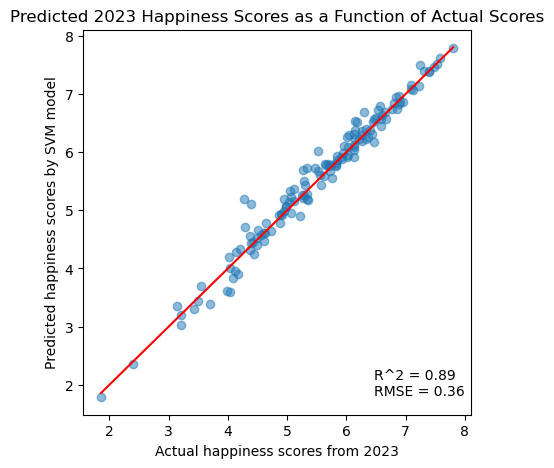

In [47]:
# Predict the 2023 data using the trained model
y_pred_2023 = model.predict(scaler.transform(X_encoded_2023))

# Create a scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_2023, y_pred_2023, alpha=0.5)
plt.xlabel('Actual happiness scores from 2023')
plt.ylabel('Predicted happiness scores by SVM model')
plt.title('Predicted 2023 Happiness Scores as a Function of Actual Scores')

# Line of equality
plt.plot([min(y_2023), max(y_2023)], [min(y_2023), max(y_2023)], color='red')

# annotate
avg_r2 = np.mean(r2_scores)
avg_rmse = np.mean(rmse_scores)
plt.annotate(f'R^2 = {avg_r2:.2f}\nRMSE = {avg_rmse:.2f}', xy=(0.75, 0.05), xycoords='axes fraction')

plt.show()

1. The points fall along the line of equality. The closer the points are to this line, the more accurate the model's predictions are.
2. There is a tight cluster of points around the line of equality, implying a more precise model.
3. There is no systematic pattern to the points deviating from the line of equality (for example, if points for lower actual values are consistently overpredicted), this could indicate that the model does not have a bias / captures the relationship between the predictors and the outcome variable.

## Further performance evaluations

### Does our prediction model have a lot of error?


 visualizes the errors in out predictions. Ideally, residuals should be randomly and evenly distributed around the x-axis, and shouldn't form any discernible pattern.

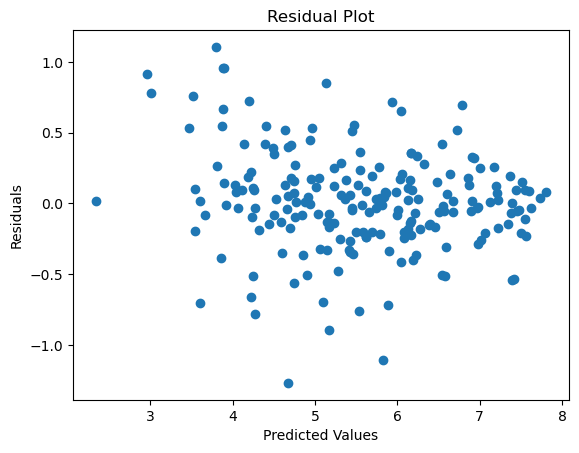

In [48]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### How much are our predictions off by?
**What does the distribution mean in plain words?**

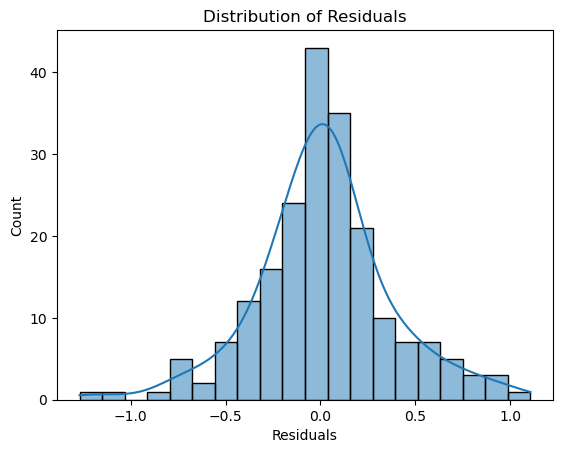

In [49]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

* Hard to predict the future! Just because our model performed well on 2023 data, there is no guarantee it will perform as well on the next year's data. The underlying relationships between variables might change over time. A model can make predictions for 2024, but we won't be able to validate these predictions against actual values as we did for the previous years, because the real 2024 data is not available yet.

* If there are large year-to-year fluctuations in happiness scores or the predictors, the model might not produce accurate predictions for 2024.
* the predictions are essentially a replication of 2023's data with some minor alterations due to the model. They don't account for potential new information or significant changes that may occur in 2024.

# **Q2:** Can we predict 2024 happiness?

Since our model performed so well, it is reasonable to try an use to forecast the upcoming year.

## Format data

To avoid data leakage, we need to split our data into training and test sets before scale our data.

### Split the data into dependent and independent variables

Where as in the 2023 model, the training and test dataset did not include 2023 data. In this model, 2023 data is included too.

In [365]:
# we will make a copy of our df so as to not modify the original.
X = df.drop('happiness', axis=1).copy()
y = df['happiness'].copy()

### One-hot encoding

In [366]:
X_encoded = pd.get_dummies(X, columns=['country'])
X_encoded.head()

,year,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption,country_Afghanistan,country_Albania,country_Algeria,...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Yemen,country_Zambia,country_Zimbabwe
0,2008,7.350,0.451,50.5,0.718,0.168,0.882,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,7.509,0.552,50.8,0.679,0.191,0.850,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,7.614,0.539,51.1,0.600,0.121,0.707,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,7.581,0.521,51.4,0.496,0.164,0.731,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,7.661,0.521,51.7,0.531,0.238,0.776,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting into training and test set & scaling

In [367]:
# lets create folds and tell the KFold function whether or not to shuffle the data beforehand.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Initialize the scaler
scaler = StandardScaler()

# Prepare empty lists to hold the training and testing data for each fold
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for train_index, test_index in kf.split(X_encoded):
    # Split the data
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the scaler on the training set and transform both sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Append to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

## Building support vector machine

In [53]:
# Initialize the SVR model
model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8976094975041727
Average RMSE: 0.35793757576772134
Average Accuracy:  0.8625820769597594


these metrics are computed within a cross-validation loop for the support vector regression model. This is what is happening:

1. In each fold of the cross-validation, the dataset is split into a training set (X_train, y_train) and a testing set (X_test, y_test). The specific split depends on the fold - different folds will have different splits of the data into training and testing sets.
2. The model is then fitted on the training data and used to predict the outputs (y_pred) for the test data (X_test).
3. These predictions are then compared to the true outputs for the test data (y_test) to compute the R^2 score, the root mean square error (RMSE), and the accuracy.
These are the metrics computed based on the predicted and actual values within each cross-validation fold (not on the actual 2023 and predicted 2024 values).

Why are we doing this? By computing the metrics on the predicted and actual values within each cross-validation fold during the model training and validation phase, we can estimate how well the model is expected to perform on unseen 2024 data based on our available data.

 R^2 = `0.898`, RMSE = `0.358`, Accuracy =  `86.3%`

The SVM preformed really well.


## Preparing X variables for 2024 forecasting

After training our Support Vector Machine model on the data from 2005-2023, we will use this trained model to forecast the 'happiness' score (y) for the year 2024.

However, in order to make this prediction, we will first need the predictor variables (X) for the year 2024.

Since the predictor variables for 2024 are time-independent, we can simply extract the most recent available data for those variables.

In [368]:
X_2024 = df[df['year'] == 2023] # Get the most recent data for each country
X_2024 = X_2024.drop('happiness', axis=1) # Remove the 'happiness' column, as it's the target variable

# we need to make sure X_2024 is processed in the same way as our training data (2005-2023)

# One-hot encode the 'country' column to match the training data
X_2024_encoded = pd.get_dummies(X_2024, columns=['country'])

# Ensure that the 2024 data has the same columns as the training data
missing_cols = set(X_encoded.columns) - set(X_2024_encoded.columns)
for c in missing_cols:
    X_2024_encoded[c] = 0

# Make sure the columns are in the same order as in the training data
X_2024_encoded = X_2024_encoded[X_encoded.columns]

# Scale the 2024 data using the same scaler object used on the training data
X_2024_scaled = scaler.transform(X_2024_encoded)

Let's add confidence intervals for our prediction. 

Since SVMs are not probailistic models, they do not inherently provide a way for us to calculate confidence intervals (unlike e.g., linear regression). However, we can use a rough approach to generate confidence intervals for our model through bootstrapping. Using bootstrapping will allow us to draw samples from the dataset we used to predict 2024 data. It then replaces the taken samples to fit the model again and again, giving us a distribution of the estimates. With this distribution, we can take it's percentiles to create confidence intervals.

In SVMs, these intervals do not necessarily capture the model's uncertainty about its predictions (unlike models that assume a normal distribution e.g., bayesian model), but rather the variability in the predictions that arises when re-fitting the model to different samples of the data.

A 95% confidence interval, in our case, means that if we were to repeat the sampling process many times, we would expect the true value to fall within this interval 95% of the time. However, this interpretation doesn't imply that there's a 95% chance the true value is within the interval; rather, it's a statement about the method's reliability if the process was repeated many times.

Bootstrapping is very computationally expensive. In our case, it took **1hr 7min**. To save on time for future runs on this script, we have **commented-out the actual code** and also saved the results from initial bootstrapping into `bootstrap_predictions` incase the kernel is reset. However, if any changes are made to the model or dataset, then the below block will need to be re-run.

In [120]:
# import time # we will add a timer to see how long it takes to bootstrap our model.
# start_time = time.time()

# from sklearn.utils import resample

# # Initialize the SVR model
# model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# n_iterations = 1000  # Number of bootstrap samples to create
# bootstrap_prediction_list = []

# # Fitting and evaluating the model for each fold
# for i in range(kf.get_n_splits()):
#     # Get the data for this fold
#     X_train = X_train_list[i]
#     X_test = X_test_list[i]
#     y_train = y_train_list[i]
#     y_test = y_test_list[i]

#     # Fitting the model and make predictions
#     model.fit(X_train, y_train)

#     for _ in range(n_iterations):
#         # Preparing a bootstrap sample
#         X_train_resample, y_train_resample = resample(X_train, y_train)
        
#         # Fitting model on the bootstrap sample
#         model_resample = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto').fit(X_train_resample, y_train_resample)
        
#         # Predicting on the 2024 data
#         y_pred_2024_resample = model_resample.predict(X_2024_scaled)
        
#         bootstrap_prediction_list.append(y_pred_2024_resample)

# bootstrap_predictions = np.array(bootstrap_prediction_list)

# # Calculating lower and upper percentiles
# lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
# upper = np.percentile(bootstrap_predictions, 97.5, axis=0)




# end_time = time.time()
# print("Execution time: ", end_time - start_time, "seconds")

Execution time:  4049.783894777298 seconds


let's save the bootstrapping results in a new dataframe so that we don't have to run the above block again.

In [369]:
# save Cl to csv file (create data frame, then save as a csv)
confidence_intervals = pd.DataFrame( 
    {'lower': lower,
     'upper': upper}
)
confidence_intervals.to_csv('Pipeline Outputs/confidence_intervals.csv', index=False) 

# we can then read the data back in 
np.savez('Pipeline Outputs/confidence_intervals.npz', lower=lower, upper=upper) # Save to a numpy file

# bring data back
data = np.load('Pipeline Outputs/confidence_intervals.npz')
lower = data['lower']
upper = data['upper']

Create a plot with the confidence intervals.

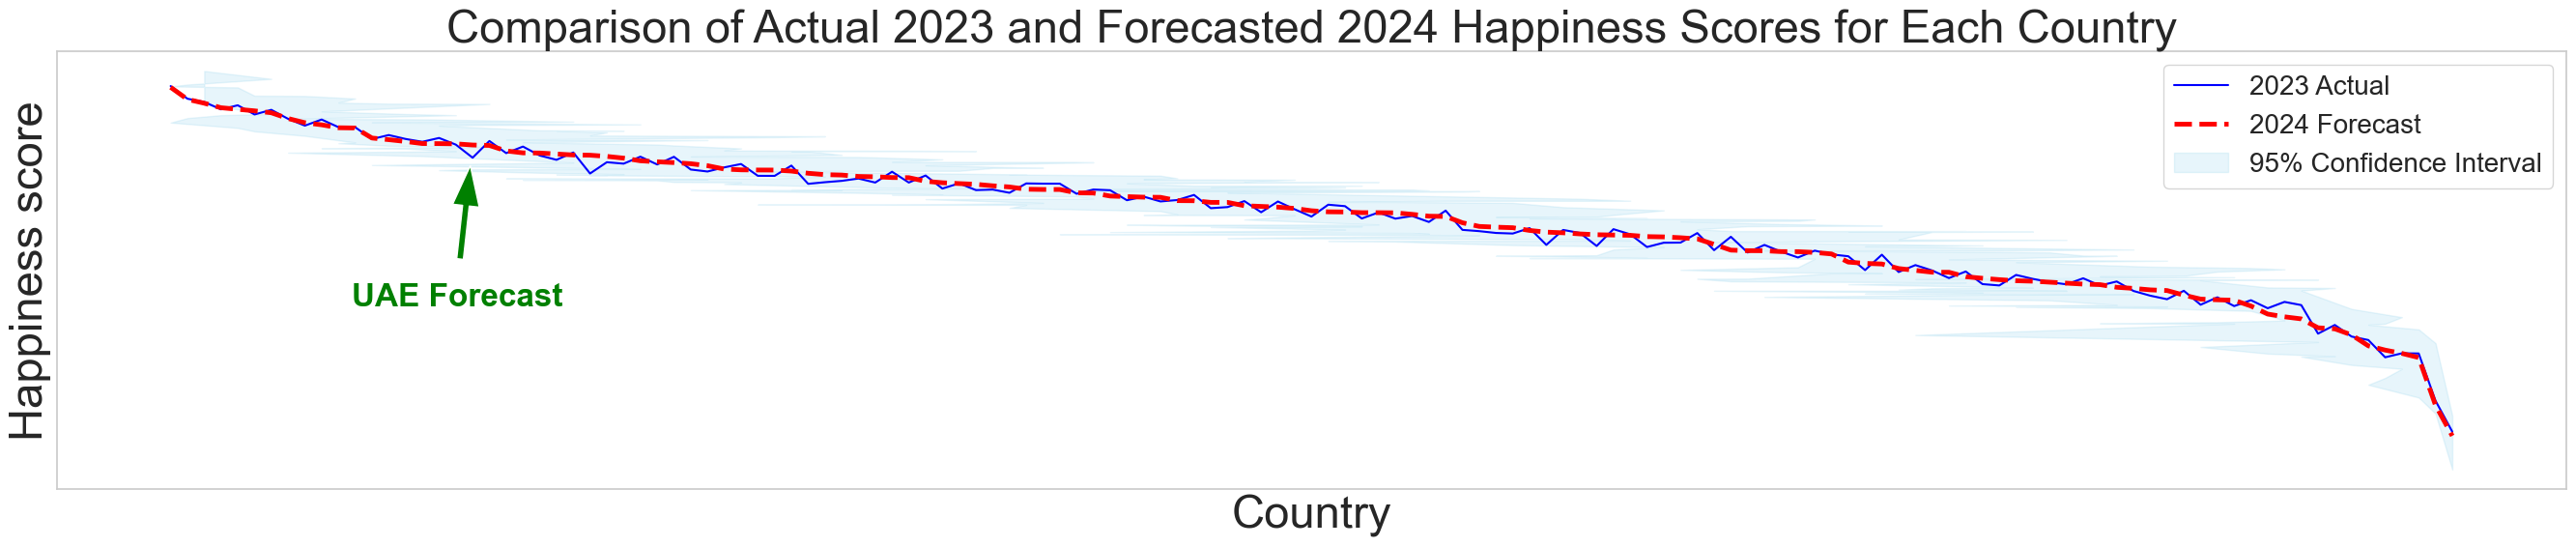

In [370]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(27, 6))

# actual 2023 happiness scores
plt.plot(df_2023_sorted['country'], df_2023_sorted['happiness'], label='2023 Actual', color='blue', linewidth=1.5)

# forecast
plt.plot(df_pred_2024_sorted['country'], df_pred_2024_sorted['happiness'], label='2024 Forecast', color='red', linestyle='dashed', linewidth=3.5)

# Add the confidence intervals to the plot
plt.fill_between(df_lower_sorted['country'], df_lower_sorted['happiness'], df_upper_sorted['happiness'], color='skyblue', alpha=0.2)

# Add annotation to show where the UAE is
# Get the index of UAE in 2024 predictions
index_uae = df_pred_2024_sorted[df_pred_2024_sorted['country']=='United Arab Emirates'].index[0]
# Get the happiness score of UAE in 2024 predictions
happiness_uae = df_pred_2024_sorted.loc[index_uae, 'happiness']

plt.annotate('UAE Forecast', 
             xy=('United Arab Emirates', happiness_uae), 
             xytext=(-90, -120),
             textcoords='offset points', 
             color = 'green',
             weight = 'bold',
             arrowprops=dict(facecolor='green', 
                             shrink=0.15, width=5, headwidth=20, headlength=30),
             fontsize=24)
# styling
plt.xlabel('Country', fontsize=34)
plt.ylabel('Happiness score', fontsize=34)
plt.title('Comparison of Actual 2023 and Forecasted 2024 Happiness Scores for Each Country', fontsize=34)
#plt.xticks(fontsize=12, rotation=90) # Rotate x-axis labels for better readability
plt.xticks([])
plt.yticks([])
plt.yticks(fontsize=12)
plt.legend(['2023 Actual', '2024 Forecast', '95% Confidence Interval'], fontsize=20)

# Remove grid lines and set background to white
plt.grid(False)
plt.gca().set_facecolor('white')

plt.tight_layout() # ensures that the full labels of the x-axis are displayed
plt.savefig('Pipeline Outputs/Figures/happiness_forecast.png')

plt.show()


Visually, it seems like all countries have a forecast that falls in the confidence interval. However, it is hard to tell for Finland, denmark and iceland if that is actually the case. Let's check:

In [371]:
# Merge all predictions and their confidence intervals into a single DataFrame
df_all = df_pred_2024_sorted.merge(df_lower_sorted, on='country', suffixes=('_pred', '_lower'))
df_all = df_all.merge(df_upper_sorted, on='country')
df_all.rename(columns={'happiness': 'happiness_upper'}, inplace=True)

outliers = [] # Initialize a list to hold the names of countries that do not fall within the confidence interval

# Check each country
for i in df_all.index:
    if not df_all.loc[i, 'happiness_lower'] <= df_all.loc[i, 'happiness_pred'] <= df_all.loc[i, 'happiness_upper']:
        outliers.append(df_all.loc[i, 'country'])

# Print 
if outliers:
    print("The following countries do not fall within the confidence interval:")
    for country in outliers:
        print(country)
else:
    print("All countries fall within the confidence interval.")

All countries fall within the confidence interval.


Since no prediction falls outside the confidence interval, it suggests that the model's prediction is in line with the variability observed in the data during bootstrapping. However, we need to remeber that there is an implication that we expect 5% of predictions to fall outside the interval due to random variation alone. But overall, since the 2024 model's predictions frequently fall inside the confidence interval, we are able to capture the most important aspects of the data.

We cannot further asses the performance of the 2024 regression model since since we are trying to forecast future unseen data. We cannot validate these predictions until the actual 2024 data is released in order to compute metrics such as R^2, RMSE, and accuracy for the 2024 forecasts. We did however previsiously train the SVM model, conducted cross-validation, and calculated the associated metrics on the cross-validation folds, which gave us an estimate of how well our model generalizes to unseen data based on the training data we had available (in this case, data up to and including 2023).

Let's visualize the percent changes for each country.

In [372]:
df_2024 = pd.DataFrame({
    'country': X_2024['country'],
    '2023_value': df[df['year'] == 2023]['happiness'],  # Get 2023 happiness values from the original dataframe
    'predicted_2024_value': y_pred_2024
})

# Calculate the percent change from 2023 to 2024
df_2024['percent_change'] = ((df_2024['predicted_2024_value'] - df_2024['2023_value']) / df_2024['2023_value']) * 100

In [293]:
df_2024_merged

,country,2023_value,predicted_2024_value,percent_change,Change
36,Malta,6.300,6.614762,4.996226,Positive
90,Guinea,5.072,5.291386,4.325441,Positive
134,Sierra Leone,3.138,3.262106,3.954933,Positive
92,Ivory Coast,5.053,5.246733,3.834026,Positive
121,Togo,4.137,4.286420,3.611797,Positive
93,Gabon,5.035,5.214204,3.559168,Positive
25,United Arab Emirates,6.571,6.789765,3.329248,Positive
49,El Salvador,6.122,6.303844,2.970329,Positive
129,Comoros,3.545,3.645491,2.834735,Positive
126,Madagascar,4.019,4.119212,2.493462,Positive


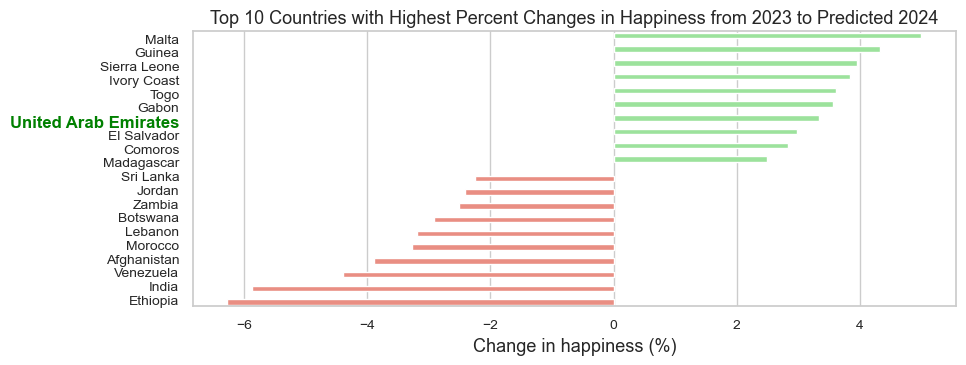

In [307]:
df_2024_positive = df_2024[df_2024['percent_change'] > 0].sort_values('percent_change', ascending=False).head(10)

df_2024_negative = df_2024[df_2024['percent_change'] < 0].sort_values('percent_change', ascending=True).head(10)
df_2024_negative = df_2024_negative.sort_values('percent_change', ascending=False)

df_2024_positive['Change'] = 'Positive'
df_2024_negative['Change'] = 'Negative'

df_2024_merged = pd.concat([df_2024_positive, df_2024_negative])

plt.figure(figsize=(10, 4))
sns.barplot(data=df_2024_merged, y='country', x='percent_change', hue='Change', palette=['lightgreen', 'salmon'])
plt.xlabel('Change in happiness (%)',fontsize=13)
plt.ylabel('')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
for label in plt.gca().get_yticklabels(): # Highlight 'United Arab Emirates' y label
    if label.get_text() == 'United Arab Emirates':
        label.set_color('green')  
        label.set_weight('bold')  
        label.set_size(12)  
        
plt.title('Top 10 Countries with Highest Percent Changes in Happiness from 2023 to Predicted 2024', fontsize=13)
plt.legend().remove()
plt.savefig('Pipeline Outputs/Figures/happiness_forecast_percentage_change.png', bbox_inches='tight')

plt.tight_layout()
plt.show()


## Limitations

#  **Q3:** Which variables are most strongly associated with happiness?



Looking at the forecast for global happiness in the upcoming year is interesting. For an example, the UAE is expected to witness the largest positive change in their happiness compared to other countries.

What would be even more interesting, is to investigate what are the most salient features that associated with predicting happiness on a global scale. 

## Which variables have the largest influence on determining happiness?

[Reference](https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa) used to write this code.

In this code, we calculate the permutation importances for each split in the KFold cross-validation. Then we store these importances in a DataFrame, which allows us to easily calculate the average importance for each feature. Finally, we sort the DataFrame by the average importance to easily see which features are most important. 

 To compute permutation importance on validation sets during cross-validation, we can use the same logic and integrate it into our cross-validation loop.

 This way, we are not using our test set for the calculation of permutation importance but rather using the validation sets from the cross-validation. Note that the `X_test` and `y_test` are essentially acting as validation sets here, as they are different subsets of our training data in each iteration of the cross-validation.



**Expect run time to take long (~5-8 minutes)**. After initial run we saved results csv file so we can later re-use it without having to wait to long. If dataset or model changes, un-comment the below block and run the permutation importance again. 

In [318]:
# # Initialize a dataframe to store importances for each fold
# importances_df = pd.DataFrame()

# # Loop over each split
# for i in range(kf.get_n_splits()):

#     # Get the data for this fold
#     X_train = X_train_list[i]
#     X_test = X_test_list[i] # In this case, X_test acts as a validation set
#     y_train = y_train_list[i]
#     y_test = y_test_list[i] # And y_test acts as validation labels

#     # Fit the model
#     model.fit(X_train, y_train)

#     # Compute the permutation importances
#     perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

#     # Get feature names
#     feature_names = X_encoded.columns.tolist()

#     # Get importances and convert them into a dataframe
#     importances = pd.DataFrame(perm.feature_importances_, index=feature_names, columns=[f'Importance Fold {i}'])

#     # Concatenate the current fold's importances with the previous ones
#     importances_df = pd.concat([importances_df, importances], axis=1)

# # Compute the average importances
# importances_df['Average Importance'] = importances_df.mean(axis=1)

# # Sort the importances
# importances_df = importances_df.sort_values('Average Importance', ascending=False)

In [373]:
#saving results locally so we can use it again later without running the above block
importances_df.to_csv('Pipeline Outputs/importances_df.csv', index=False) 
np.savez('Pipeline Outputs/importances_df.npz', importances_df=importances_df.values) # save as numpy array 

#saving results locally so we can use it again later without running the above block
importances_df.to_csv('Pipeline Outputs/importances_df.csv', index=False) 
np.savez('Pipeline Outputs/importances_df.npz', importances_df=importances_df.values) # save as numpy array 

print(importances_df)

                   Average Importance
GDP                          0.486848
socialSupport                0.205741
corruption                   0.093848
freedom                      0.063421
country_Singapore            0.054672
...                               ...
country_Cuba                 0.000036
country_Maldives             0.000034
country_Oman                 0.000020
country_Suriname             0.000007
country_Guyana              -0.000001

[172 rows x 1 columns]


In [374]:
importances_df = importances_df[['Average Importance']]
importances_df.head()

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
country_Singapore,0.054672


We want to create a visualization, but we want the countries to have different color than the other variables i.e., GDP, for clarity.

In [375]:
# create a boolean mask indicating whether each index contains the string 'country'. we will use this to filter the dataframe.

# Create a boolean mask
mask = importances_df.index.str.contains('country')

# Create DataFrame for features containing 'country'
df_importanceCountry = importances_df[mask]

# Create DataFrame for features not containing 'country'
df_importanceNon_country = importances_df[~mask]

In [376]:
# Remove 'country_' from the index
df_importanceCountry.index = df_importanceCountry.index.str.replace('country_', '', regex=False)
df_importanceCountry.head()

,Average Importance
Singapore,0.054672
Hong Kong S.A.R. of China,0.052752
Ireland,0.049348
Luxembourg,0.046483
Estonia,0.045628


In [377]:
# lets create a color map
def color_negative_red(value):
  """
  Colors values in a DataFrame green if they are positive and red if they are negative.

  Args:
    value (float): The value to color.

  Returns:
    str: The color string.
  """
  if value < 0:
    color = 'red'
  else:
    color = 'green'

  return 'color: %s' % color

In [378]:
# Apply the color map to dataframe for feature imoportance by country
styledCountry = df_importanceCountry[['Average Importance']].style.applymap(color_negative_red)

styledCountry

,Average Importance
Singapore,0.054672
Hong Kong S.A.R. of China,0.052752
Ireland,0.049348
Luxembourg,0.046483
Estonia,0.045628
Japan,0.040881
United Arab Emirates,0.036113
Germany,0.034091
United Kingdom,0.032976
France,0.032374


In [379]:
# Apply the color map to dataframe for feature imoportance by scores
styledScores = df_importanceNon_country[['Average Importance']].style.applymap(color_negative_red)

styledScores

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
generosity,0.053210
year,0.050054
lifeExpectancy,0.020406


In [380]:
df_importanceNon_country.head()

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
generosity,0.053210


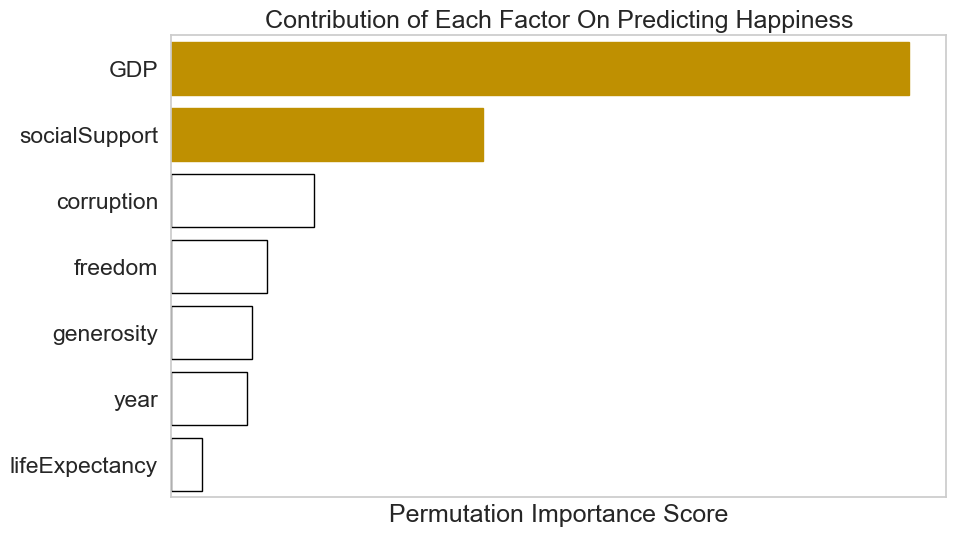

In [381]:
# sort in descending order
df_importanceNon_country_sorted = df_importanceNon_country.sort_values(by='Average Importance', ascending=False)

# create a horizontal bar plot with all bars as white
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=df_importanceNon_country_sorted['Average Importance'], y=df_importanceNon_country_sorted.index, color='white', edgecolor='black', lw=1)

# Set specific bars to a different color (in this case, the two bars with the highest importance)
bars.patches[0].set_color('#BF9001')
bars.patches[1].set_color('#BF9001')

plt.xlabel("Permutation Importance Score")
plt.ylabel('')
plt.title("Contribution of Each Factor On Predicting Happiness")
plt.xticks([])

plt.savefig('Pipeline Outputs/Figures/factors_predict_happiness.png', bbox_inches='tight')

plt.show()

## Are there any interacting variables that predict happiness?

Pairplots can be used to visualize potential interactions between features in relation to the target variable. To create this we just need  a 3D plot that can illustrate the relationship between two features and the target variable (happiness).

In [361]:
# the feature names are from this df
print(X_encoded.columns)

Index(['year', 'GDP', 'socialSupport', 'lifeExpectancy', 'freedom',
       'generosity', 'corruption', 'country_Afghanistan', 'country_Albania',
       'country_Algeria',
       ...
       'country_United Arab Emirates', 'country_United Kingdom',
       'country_United States', 'country_Uruguay', 'country_Uzbekistan',
       'country_Venezuela', 'country_Vietnam', 'country_Yemen',
       'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=172)


In [382]:
# what are all the possible combinations of features that we can plot?
# the features we are interested in are: GDP, socialSupport, corruption, freedom, generosity, year,and, lifeExpectancy

from itertools import combinations

features = ['GDP', 'socialSupport', 'corruption', 'freedom', 'generosity', 'year', 'lifeExpectancy']

# Get all possible combinations of 2 features
feature_combinations = list(combinations(features, 2))

# let's print them
for combo in feature_combinations:
    print(combo)

('GDP', 'socialSupport')
('GDP', 'corruption')
('GDP', 'freedom')
('GDP', 'generosity')
('GDP', 'year')
('GDP', 'lifeExpectancy')
('socialSupport', 'corruption')
('socialSupport', 'freedom')
('socialSupport', 'generosity')
('socialSupport', 'year')
('socialSupport', 'lifeExpectancy')
('corruption', 'freedom')
('corruption', 'generosity')
('corruption', 'year')
('corruption', 'lifeExpectancy')
('freedom', 'generosity')
('freedom', 'year')
('freedom', 'lifeExpectancy')
('generosity', 'year')
('generosity', 'lifeExpectancy')
('year', 'lifeExpectancy')


In [363]:
# above we found all the possible combinations. So how many combination in total can we plot?
print(len(feature_combinations))

21


We have 21 possible plots to make. We could manually make a plot for each pair, but lets make our life easier and just use a loop to do it all at once.

In [383]:
df_subset.reset_index(drop=True, inplace=True)
sns.pairplot(df_subset, kind='reg')
plt.show()

NameError: name 'df_subset' is not defined

The pairplots above allows us to visually see which two features are dependent on each other. Let's compute the R-squared to numerically determine which two pairs are goof predictors of each other.

An R-squared value ranges from 0 to 1. A high R-squared value, closer to 1, indicates that a large proportion of the variability in the dependent variable is accounted for by the independent variable(s).

In the context of the relationship between two variables, a high R-squared value would mean that there's a strong linear relationship between the two variables. More specifically, it means that the independent variable is a good predictor of the dependent variable, as it accounts for a large proportion of the observed variation in the dependent variable. In other words, how well does the change in the independent variable predict the change in the dependent variable.

Simimlar to [Kaur et al., 2019](https://www.mdpi.com/2076-3417/9/8/1613), we will use RSME to evaluate performance. The lower values of RMSE indicated better fit models. 

In [118]:
model = LinearRegression() # Initialize the model

df_no_country_happiness = df.drop(columns=['country', 'happiness']) # Remove country and happiness columns

metrics_df = pd.DataFrame(columns=['r','R-squared', 'RMSE']) # Prepare dataframe to store R-squared and RMSE values

# Loop over each pair of columns
for i, col1 in enumerate(df_no_country_happiness.columns):
    for j, col2 in enumerate(df_no_country_happiness.columns):
        # Skip when columns are the same
        if i < j:
            # Fit the model
            model.fit(df_no_country_happiness[[col1]], df_no_country_happiness[col2])
            # Get r
            r = scipy.stats.pearsonr(df_no_country_happiness[col1], df_no_country_happiness[col2])[0]
            # Get R-squared
            r_squared = model.score(df_no_country_happiness[[col1]], df_no_country_happiness[col2])
            # Predict values
            predictions = model.predict(df_no_country_happiness[[col1]])
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(df_no_country_happiness[col2], predictions))
            # Store R-squared and RMSE
            metrics_df.loc[f'{col1} vs {col2}'] = [r, r_squared, rmse]

# Sort the dataframe such that the models with the highest correlation are at the top
metrics_df['abs_r'] = metrics_df['r'].abs() # we'll sort by absolute value so that strong negative relationships are also near the top of the dataframe
metrics_df = metrics_df.sort_values('abs_r', ascending=False)

print(metrics_df)


                                        r  R-squared      RMSE     abs_r
GDP vs lifeExpectancy            0.805471   0.648784  4.035998  0.805471
GDP vs socialSupport             0.672463   0.452206  0.089716  0.672463
socialSupport vs lifeExpectancy  0.596624   0.355960  5.465379  0.596624
freedom vs corruption           -0.468796   0.219770  0.162530  0.468796
socialSupport vs freedom         0.410315   0.168358  0.126642  0.410315
lifeExpectancy vs freedom        0.372909   0.139061  0.128853  0.372909
GDP vs corruption               -0.364998   0.133224  0.171307  0.364998
GDP vs freedom                   0.361559   0.130725  0.129475  0.361559
freedom vs generosity            0.314469   0.098891  0.150664  0.314469
lifeExpectancy vs corruption    -0.288514   0.083240  0.176177  0.288514
generosity vs corruption        -0.270057   0.072931  0.177165  0.270057
year vs freedom                  0.235856   0.055628  0.134952  0.235856
socialSupport vs corruption     -0.225346   0.05078

`GDP vs lifeExpectancy` , `GDP vs socialSupport`, and  `socialSupport vs lifeExpectancy` have a correlation that is either at a moderate or above moderate strength. These will be our candidates.

According to the r-squared;
* `GDP` explains `64.9%` of the vairance in `lifeExpectancy`.
* `GDP` explains `45.2%` of the vairance in `socialSupport`.
* `socialSupport` explains `35.6%` of the vairance in `lifeExpectancy`.

These three relationships appear to be dependent on each other. 

It turns out `GDP` is predictive of both `lifeExpectancy` and `socialSupport`. Let's model that!

Static plots 3d are hard to visually inspect, so we will also make an interactive one too.

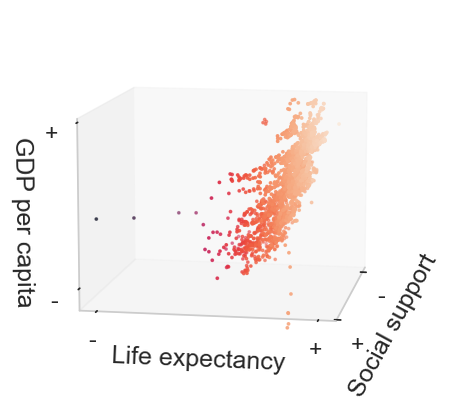

In [348]:
scaler_life_social = StandardScaler() # Create a new scaler for the features
X_life_social  = scaler_life_social.fit_transform(X_encoded[['socialSupport', 'lifeExpectancy']]) # Fit and transform the features


x = X_life_social[:, 0]  # social support
y = X_life_social[:, 1]  # life expectancy
z = X_encoded[['GDP']].values.ravel()  # GDP per capita. our z value needs to be a 1d array, not column from df
# Create an interactive3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='Social support'),
                             yaxis=dict(title='Life expectancy'),
                             zaxis=dict(title='GDP per capita')),
                  title='GDP as a function of social support and life expectancy')

fig.update_layout(scene=dict(
    xaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
    yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
    zaxis=dict(title='GDP per capita', tickvals=[6, 11], ticktext=['-', '+'], showticklabels=True)),
    title='GDP as a function of social support and life expectancy'
)


fig.show()

# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=y, marker='o', s=3) # setting color = y elucidates dimensionality despite graph being 2d


ax.set_xlabel('Social support')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('GDP per capita')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference

ax.set_xlim([-5, 1])  # set the range 
ax.set_ylim([-8, 2])  # set the range 
ax.set_zlim([6, 11])  # set the range 

ax.set_xticks([-4.5,1])  
ax.set_yticks([-7.5,1.5])
ax.set_zticks([6.5,11])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA


ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.savefig('Pipeline Outputs/Figures/GDP_Life_Social', bbox_inches='tight')

plt.show()

Importance permutation performed earlier revealed the ranking of which independent variable has the greatest influence on our tagret variable, happiness in the SVM regression. 

Now that we have 3 candidates from our linear regression, lets see if any of the pairs of independent variables are good predictors of happiness. 

Where importance permutation was a univariate analysis, now we will perform a type of multivariate analysis to see if perhaps happiness is perdicted by a combination of independent variables, rather than just one.

To conduct this analysis, we will add a third dimension (z-axis) that will represent happiness, with the pairs `GDP vs lifeExpectancy` , `GDP vs socialSupport`, and  `socialSupport vs lifeExpectancy` plotted on the x- and y-axis.

For plots where we observe that there is a strong linear relationship between two variables, let's check to see if the combination of those to also are predictors of happines.

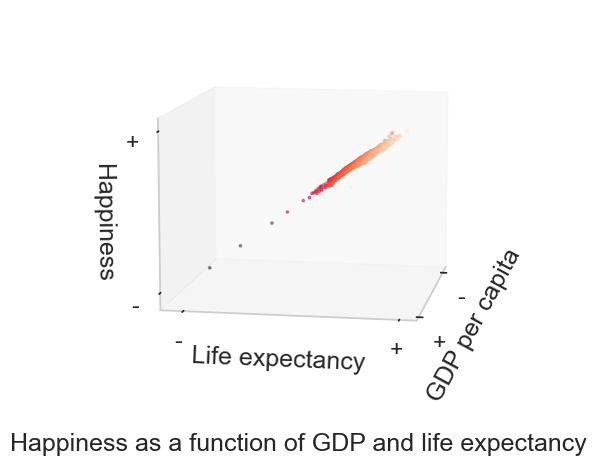

In [345]:
scaler_GDP_life = StandardScaler() # Create a new scaler for the features
X_GDP_life = scaler_GDP_life.fit_transform(X_encoded[['GDP', 'lifeExpectancy']]) # Fit and transform the features


x = X_GDP_life[:, 0]  # GDP per capita
y = X_GDP_life[:, 1]  # life expectancy
z = y  # Happiness scores

# Create an interactive3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='GDP per capita',tickvals=[6, 11], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of GDP and life expectancy')

fig.show()


# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o',s=3) # setting color = z elucidates dimensionality despite graph being 2d


ax.set_xlabel('GDP per capita')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('Happiness')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- reference
ax.set_xticks([-3, 2])  
ax.set_yticks([-8,2])
ax.set_zticks([-8, 2])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.figtext(0.5, 0.01, 'Happiness as a function of GDP and life expectancy', ha='center', va='center')

plt.savefig('Pipeline Outputs/Figures/Happiness_predictedBy_Life_gdp', bbox_inches='tight')

plt.show()

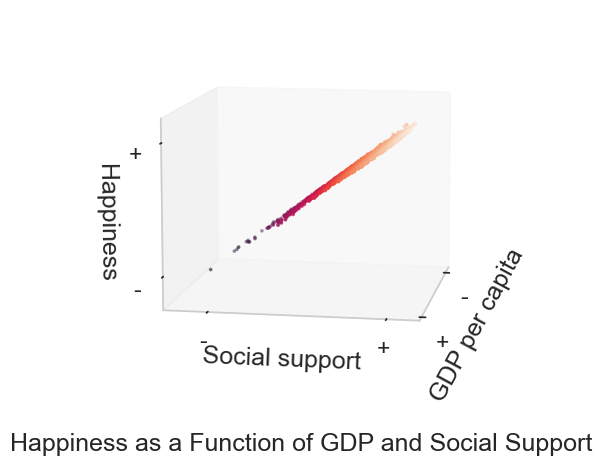

In [346]:
scaler_GDP_Social = StandardScaler()# Create a new scaler for the features
X_GDP_Social = scaler_GDP_Social.fit_transform(X_encoded[['GDP', 'socialSupport']]) # Fit and transform the features

x = X_GDP_Social[:, 0]  
y = X_GDP_Social[:, 1]  
z = y  # Happiness scores

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='GDP per capita', tickvals=[-3, 2], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of GDP and social support')

fig.show()

# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o', s=3) # setting color = z elucidates dimensionality despite graph being 2d

ax.set_xlabel('GDP per capita')
ax.set_ylabel('Social support')
ax.set_zlabel('Happiness')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference
ax.set_xticks([-3, 2])  
ax.set_yticks([-4, 1])
ax.set_zticks([-4, 1])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.figtext(0.5, 0.01, 'Happiness as a Function of GDP and Social Support', ha='center', va='center')

plt.savefig('Pipeline Outputs/Figures/Happiness_predictedBy_gdp_Social', bbox_inches='tight')

plt.show()

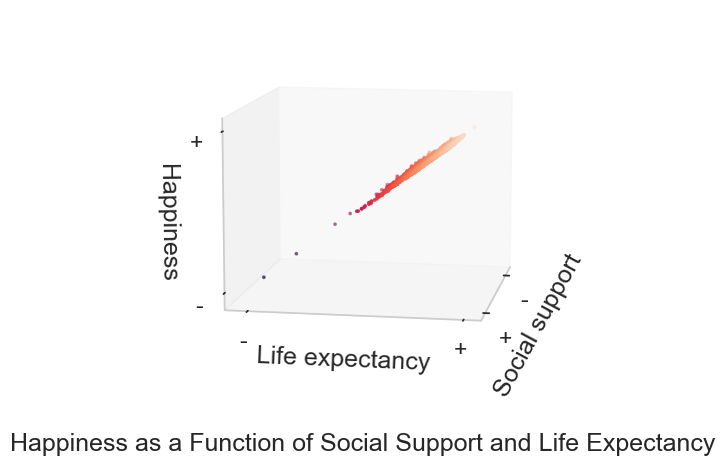

In [347]:
scaler_social_life = StandardScaler() # Create a new scaler for the features
X_social_life = scaler_social_life.fit_transform(X_encoded[['socialSupport', 'lifeExpectancy']]) # Fit and transform the features

x = X_social_life[:, 0]  
y = X_social_life[:, 1]  
z = y  # Happiness scores

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of social support and life expectancy')

fig.show()

# Create a static 3d plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o', s=3) # setting color = z elucidates dimensionality despite graph being 2d

ax.set_xlabel('Social support')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('Happiness')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference
ax.set_xticks([-4, 1])  
ax.set_yticks([-8, 2])
ax.set_zticks([-8, 2])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.figtext(0.5, 0.01, 'Happiness as a Function of Social Support and Life Expectancy', ha='center', va='center')

plt.savefig('Pipeline Outputs/Figures/Happiness_predictedBy_life_Social', bbox_inches='tight')


plt.show()